<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\indi}{\mathbb{I}}
$$

# Structured Prediction Exercises - Solutions

##  <font color='green'>Setup 1</font>: Load Libraries

In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("..")
import statnlpbook.util as util
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

## <font color='blue'>Task 1 solution</font>
We need to find a different representation and model that also achieves perfect accuracy.

There are several different ways you can represent your input and your output, for example:
- length of a sentence in characters (as presented in lecture notes)
- length of a sentence in words (presented solution)
- number of empty spaces in a sentence, as a surrogate for a length in words (question: what might be a problem with this representation?)
- ratio of English/German sentence lengths (question: what is a possible issue with this representation?)
- ...

In [2]:
def new_f(x):
    """Calculate a representation of the input `x`."""
    return len(x.split(' '))

def new_g(y):
    """Calculate a representation of the output `y`."""
    return len(y.split(' '))

As for the model, again, there are several different types of model one can think of:
- negative absolute value of scaled English length and German length (as presented in lecture notes)
- variations on the previous one, based on the position and effect of the parameter to any of the representations
- negative of a square of differences (presented solution)
- variations with ratios of representations instead of their difference (question: which problems might you expect with this model?)
...



In [3]:
def new_s(theta,x,y):
    """Measure the compatibility of sentences `x` and `y` using parameter `theta`"""
    return -pow(theta * f(x) - g(y), 2)

Before going on to the next solution, run the following code to initialise the model and representations to the ones used in the lecture notes:

In [4]:
import math
import numpy as np

x_space = ['I ate an apple', 
           'I ate a red apple', 
           'Yesterday I ate a red apple', 
           'Yesterday I ate a red apply with a friend']
y_space = ['Ich aß einen Apfel',
           'Ich aß einen roten Apfel',
           'Gestern aß ich einen roten Apfel',
           'Gestern aß ich einen roten Apfel mit einem Freund']
data = list(zip(x_space,y_space))
train = data[:2]
test = data[2:]

def f(x):
    """Calculate a representation of the input `x`."""
    return len(x)
def g(y):
    """Calculate a representation of the output `y`."""
    return len(y)

def s(theta,x,y):
    """Measure the compatibility of sentences `x` and `y` using parameter `theta`"""
    return -abs(theta * f(x) - g(y))

thetas = np.linspace(0.0, 2.0, num=1000)

## <font color='blue'>Task 2 solution</font>

We need to find a "smoother" objective that is continuous and has optima that also optimase the original zero-one loss:

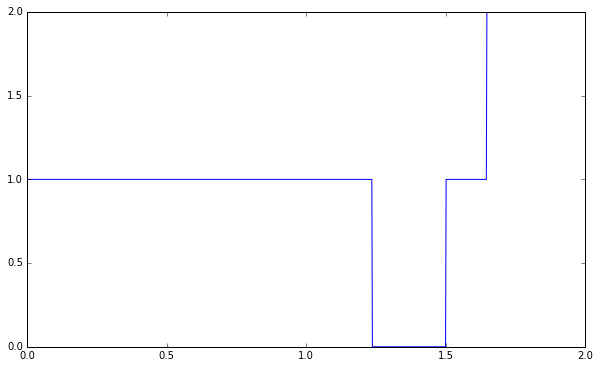

In [6]:
def zero_one_loss(theta, data):
    """Measure the total number of errors made when predicting with parameter `theta` on training set `data`"""
    total = 0.0
    for x,y in data:
        max_score = -math.inf
        result = None
        for y_guess in y_space:
            score = s(theta,x,y_guess)
            if score > max_score:
                result = y_guess
                max_score = score
        if result != y:
            total += 1.0
    return total

plt.plot(thetas, [zero_one_loss(theta,train) for theta in thetas])

Zero-one loss is a discrete loss, and we'd like to find a smoother one (question: why do we prefer smoother losses?). The problem of finding a smoother loss boils down to finding new types of loss which incorporate score information in loss calculation, specifically, some contrast between the score of a gold output structure $\y$ of $(\x,\y) \in \train$ and the score of the highest scoring German sentence $\y'_{\param}=\argmax_\y s_\param(\x,\y)$, or a combination of multiple scores for several output structures $\y \in \Ys$.

There are several different losses one might implement:

## Structured perceptron loss

$$
l(\param)=\sum_{(\x,\y) \in \train} (s_\param(\x,\y)-s_\param(\x,\y'_{\param}))
$$


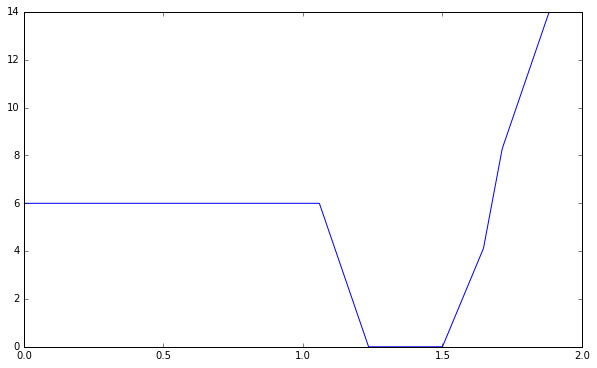

In [7]:
def structured_perceptron_loss(theta, data):
    """Measure the total number of errors made when predicting with parameter `theta` on training set `data`"""
    total = 0.0
    for x,y in data:
        max_score = -math.inf
        result = None
        for y_guess in y_space:
            score = s(theta,x,y_guess)
            if score > max_score:
                result, max_score = y_guess, score
        # the loss (per instance) is a deviation of the score of the highest-scored instance from the score of the true label
        total += max_score - s(theta, x, y)
    return total

plt.plot(thetas, [structured_perceptron_loss(theta,train) for theta in thetas])

## Structured perceptron hinge loss

$$
l(\param)=\sum_{(\x,\y) \in \train} (\sum_{\y \in \Ys}(\max(0, s_\param(\x,\y) - s_\param(\x,\y'_{\param}) + \Delta)))
$$

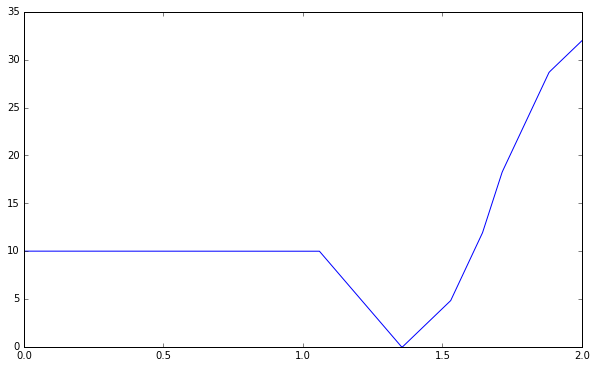

In [8]:
def hinge_loss(theta, data, delta=4.0):
    """Measure the total number of errors made when predicting with parameter `theta` on training set `data`"""
    total = 0.0
    for x,y in data:
        for y_guess in y_space:
            if y != y_guess:
                # per instance, whenever you make a mistake, add the max of zero and difference between score of every structured output increased by a margin (yet another parameter!)
                total += max(0, s(theta, x, y_guess) - s(theta, x, y) + delta)
    return total

plt.plot(thetas, [hinge_loss(theta,train) for theta in thetas])

## Log loss

$$
l(\param)=\sum_{(\x,\y) \in \train} (s_\param(\x,\y)-log(\sum_{\y \in \Ys} e^{s_\param(\x,\y'_{\param})}))
$$

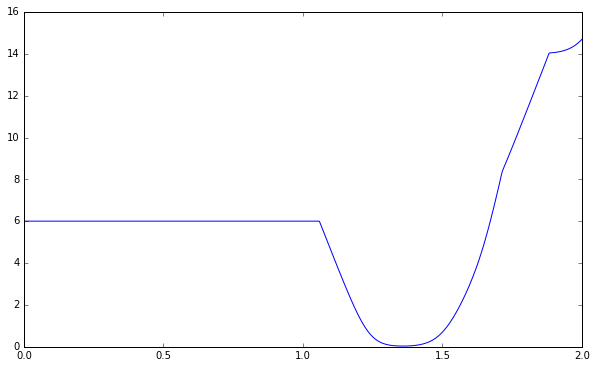

In [9]:
from math import exp, log
# cross entropy loss
def log_loss(theta, data):
    """Measure the total number of errors made when predicting with parameter `theta` on training set `data`"""
    total = 0.0
    for x,y in data:
        max_score = -math.inf
        sum_exp = 0.0
        for y_guess in y_space:
            sum_exp += exp(s(theta,x,y_guess))
        # this is a soft version of the max function called softmax
        # e to the power of score of the true output structure, divided by the sum of e to the power of score for all possible output structures
        total += -log(exp(s(theta, x, y)) / sum_exp)
    return total

plt.plot(thetas, [log_loss(theta,train) for theta in thetas])

## Loss comparison

It's useful to plot all the losses we define to visually compare them and verify that they all end up with minimum in the same interval.

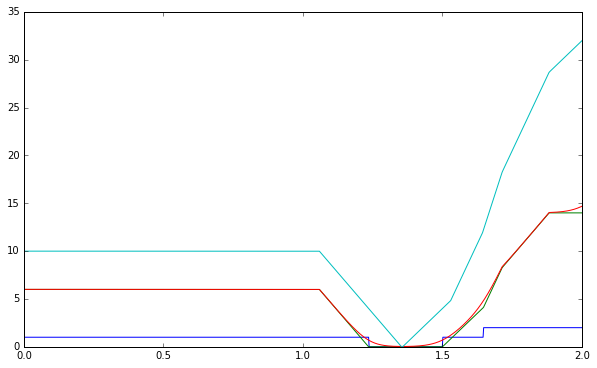

In [10]:
plt.plot(thetas, [zero_one_loss(theta,train) for theta in thetas], 
         thetas, [structured_perceptron_loss(theta,train) for theta in thetas],
         thetas, [log_loss(theta,train) for theta in thetas],
         thetas, [hinge_loss(theta,train) for theta in thetas]
        )